In [956]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fftpack import fft, fftfreq
from scipy import signal


In [984]:
def plot_obsesrvable_and_drive(x_array, drive_array,t):
    
    fig, ax1 = plt.subplots(figsize=(8,3))
    color = "steelblue"
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Displacement', color=color)
    ax1.plot(t, x_array, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()

    color = "r"
    # We already handled the x-label with ax1
    ax2.set_ylabel('Drive function', color=color)
    ax2.plot(t, drive_array, color=color, alpha = 0.2)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped


def plot_power_spectrum(t, x_array):
    """
    Compute and plot the power spectrum of a signal.
    
    Parameters:
    t: Array of time points.
    x_array: Array of signal values.
    """
    # Compute the Fast Fourier Transform (FFT) of the signal
    fft_vals = fft(x_array)

    # Compute the power spectral density (PSD)
    psd = np.abs(fft_vals) ** 2

    # Get the frequencies corresponding to the values of the PSD
    fft_freq = fftfreq(len(psd), d=(t[1]-t[0]))

    # Only keep the positive frequencies (the spectrum is symmetric)
    i = (fft_freq > 0) & (fft_freq < 100)

    # Plot the power spectrum
    plt.figure(figsize=(8, 3))
    plt.loglog(fft_freq[i], psd[i])
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density')
    plt.title('Power Spectrum')
    plt.grid(True)
    plt.show()

In [734]:
class Harmonic_Oscillator:

    def __init__(self, F, gamma, m = 1, k = 1, sigma_x = 0, sigma_v = 0):
        '''
        Defines a driven, damped harmonic oscillator:
            F(t) - kx - gamma dx/dt = d^2x/dt^2 * m
        
        To add noise, we write the second order ODE as two first order ODE,
        and add Brownian noise to x and v separately
        dv = F(t)dt - kx(t)/m dt - gamma v(t)/m dt + dW_v
        dx = v(t)dt + dW_x
            
        k: spring constant
        F: driving function
        gamma: damping constant
        m: oscillator mass
        sigma_x: additive noise to x (Brownian bombardment)
        sigma_v: additive noise to v (noise in force)
        '''        
        self.F = F
        self.gamma = gamma
        self.m = m
        self.k = k
        self.sigma_x = sigma_x
        self.sigma_v = sigma_v
        
    def _equations(self, y, t):
        """
        Express the second order ODE as two first order ODEs
        
        Parameters:
        y: List [x, v] where x is the displacement and v is the velocity.
        t: Time.
        
        Returns:
        List of the first derivatives [dx/dt, dv/dt].
        """
        x, v = y
        dxdt = v 
        dvdt = self.F(t) / self.m - self.k * x / self.m - self.gamma * v / self.m
        return [dxdt, dvdt]        
    
    def run_without_noise(self, initial_condition, T, dt):
        """
        inputs
            initial_condition: tuple (initial position, velocity)
            T: total time to integrate over
            dt: time step
        
        output: 
            x_array: a numpy array containing the displacement of the oscillator at each time step
        """
        t = np.arange(0, T, dt)
        solution = odeint(self._equations, initial_condition, t)
        x_array = solution[:, 0]
        return x_array, t    
    
    def run_with_noise(self, initial_condition, T, dt):
        """
        Use first order method to intergrate with noise
        """
        t = np.arange(0, T, dt)
        x_array = np.zeros_like(t)
        v_array = np.zeros_like(t)
        x_array[0], v_array[0] = initial_condition

        for i in range(1, t.shape[0]):
            x_array[i] = x_array[i-1] + dt * v_array[i-1] \
                        + self.sigma_x * np.sqrt(dt) * np.random.normal()
            v_array[i] = v_array[i-1] + dt * (self.F(t[i-1]) / self.m - self.k * x_array[i-1] / self.m - self.gamma * v_array[i-1] / self.m) \
                        + self.sigma_v * np.sqrt(dt) * np.random.normal()

        return x_array, t

In [627]:
class Radial_Oscillator:

    def __init__(self, F, alpha = 0.1, 𝜔 = 1, 𝜇 = 1, k = 1, sigma_r = 0, sigma_𝜙 = 0):
        '''
        Defines an oscillator in polar coodinate driven in phase,
        with noise directly added in polar-coordinates
            dr = alpha (𝜇 r dt - r^3 dt + dw_r)
            d𝜙 = 𝜔 dt + k sin(F(t) - 𝜙) dt + dw_𝜙
            
        k: coupling to drive
        𝜔: intrinsic frequency
        𝜇: Hopf control parameter (criticality at 0)
        sigma(s): noise strength        
        '''        
        self.F = F
        self.k = k
        self.𝜇 = 𝜇
        self.𝜔 = 𝜔
        self.sigma_r = sigma_r
        self.sigma_𝜙 = sigma_𝜙
        self.alpha = alpha
        
    def run_with_noise(self, initial_condition, T, dt):
        """
        Use first order method to intergrate with noise
        """
        t = np.arange(0, T, dt)
        r_array = np.zeros_like(t)
        𝜙_array = np.zeros_like(t)
        r_array[0], 𝜙_array[0] = initial_condition
        for i in range(1, t.shape[0]):
            r_array[i] = r_array[i-1] + self.alpha * (self.𝜇 * r_array[i-1] * dt - r_array[i-1]**3 * dt) \
                        + self.sigma_r * np.sqrt(dt) * np.random.normal()
            𝜙_array[i] = 𝜙_array[i-1] + self.𝜔 * dt + dt * self.k * np.sin(self.F(t[i-1]) - 𝜙_array[i-1])  \
                        + self.sigma_𝜙 * np.sqrt(dt) * np.random.normal()

        x_array = r_array * np.sin(𝜙_array)
        return x_array, t

### Test Harmonic Oscillator

In [982]:
### natural frequency is 1 by default
### with natural period = 2 Pi

T = np.pi*2 * 50
T_stop = 0

drive_f = 1
# drive_f = 0.5
# drive_f = 1.2
# drive_f = 0.8

# sigma_x = 0.2
# sigma_v = 0.2

dt = 0.001

sigma_x=0
sigma_v=0

# F = lambda t: signal.square(t * drive_f) 
def F(t):
    return 0
    if t < T_stop:
        return signal.square(t * drive_f) 
    else:
        return signal.square(T_stop * drive_f) 

np.random.seed(1)
oscillator = Harmonic_Oscillator(F, gamma=0.3, m=1, k=1, sigma_x=sigma_x, sigma_v=sigma_v)

x_array, t = oscillator.run_with_noise([1, 0], T=T, dt=dt)
# x_array, t = oscillator.run_without_noise([0, 0], T=5000*0.01, dt=0.01)


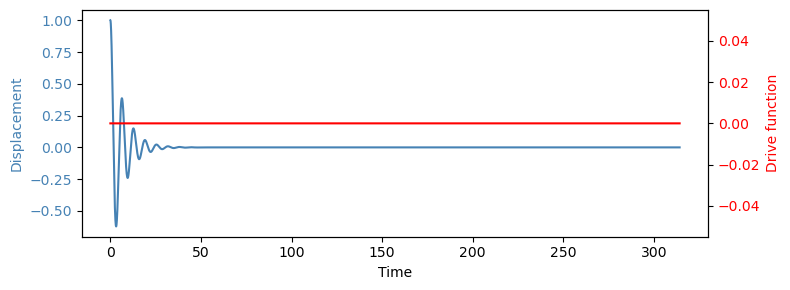

In [983]:
drive_array = [F(t) for t in t]
plot_obsesrvable_and_drive(x_array, drive_array, t)

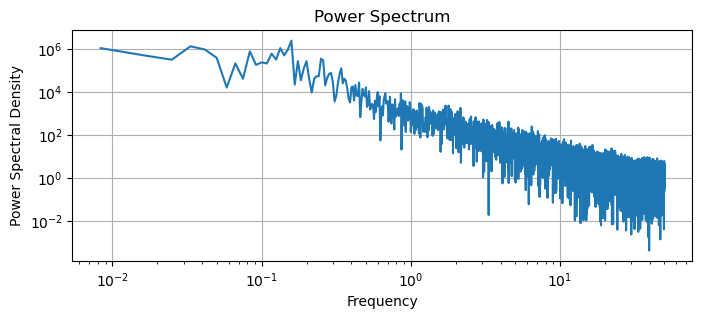

In [951]:
plot_power_spectrum(t, x_array)


### Test Radial Isochron Oscillator

In [1001]:
### natural frequency is 1 by default
# drive_f = 1
# drive_f = 0.8
drive_f = 2

T = 120
T_stop  = 120

# coupling 
k = 0.5
# sigma_r = 0.2
# sigma_𝜙 = 0.2

sigma_r = 0
sigma_𝜙 = 0
𝜇 = 1
alpha = 0.8

def F(t):
    if t < T_stop:
        return np.pi/2 * signal.square(t * drive_f)
    else:
        return np.pi/2 * signal.square(T_stop * drive_f) 
    

np.random.seed(0)
oscillator = Radial_Oscillator(F=F, k=k, 𝜇=𝜇, sigma_r=sigma_r, sigma_𝜙=sigma_𝜙)
x_array, t = oscillator.run_with_noise([1, 0], T=T, dt=dt)


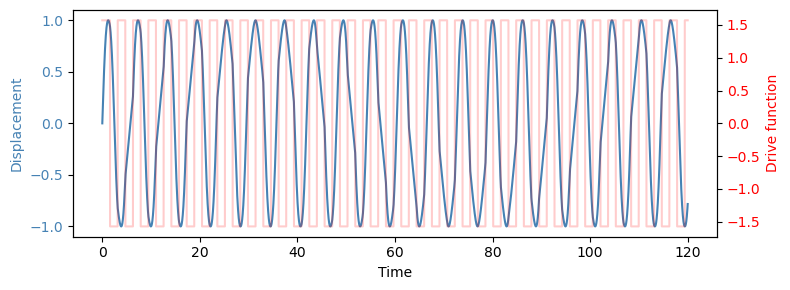

In [1002]:
drive_array = [F(t) for t in t]

plot_obsesrvable_and_drive(x_array, drive_array,t)

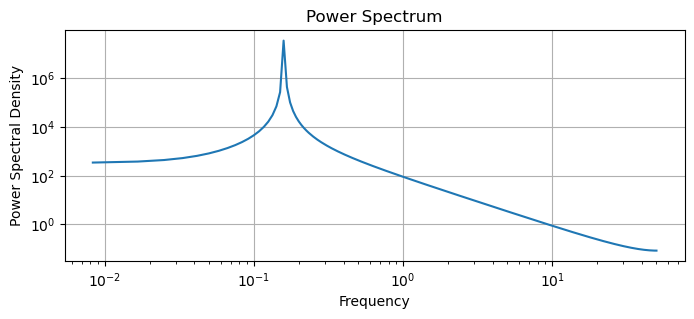

In [940]:
plot_power_spectrum(t, x_array)